## Manual testing

Images to predict should be stored in **test_data** directory.

All predicted images will be moved to **predicted** folder and the prediction are the first 3 characters of filename.

Max 30 images will be shown in the plot grid.



In [2]:
import os
from PIL import Image 
import numpy as np
import tensorflow.keras as keras
import math
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image 
from tensorflow import keras

def ziffer_data_files(input_dir):
    imgfiles = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if (file.endswith(".jpg") and not file.startswith("10_") and not file.startswith("N")):
                #print(root + "/" + file)
                imgfiles.append(root + "/" + file)
    return  imgfiles

def ziffer_data(input_dir):
    
    files = ziffer_data_files(input_dir)
    
    y_data = np.empty((len(files)))
    y_file = np.empty((len(files)), dtype="S100")
    x_data = np.empty((len(files),32,20,3))

    for i, aktfile in enumerate(files):
        base = os.path.basename(aktfile)

        # get label from filename (1.2_ new or 1_ old),
        if (base[1]=="."):
            target = base[0:3]
        else:
            target = base[0:1]
         
        category = float(target)
        
        test_image = Image.open(aktfile).resize((20, 32))
        test_image = np.array(test_image, dtype="float32")
        y_file[i] =  base
        x_data[i] = test_image
        y_data[i] =  category
    print("Ziffer data count: ", len(y_data))   
    return x_data, y_data, y_file

def move_to_pred_dir(prediction, filename, input_dirs=['test_data'], out_dir='predicted'):
    for input_dir in input_dirs:
        for root, dirs, files in os.walk(input_dir):
            for file in files:
                if file.startswith(filename):
                    shutil.move(os.path.join(root, file), os.path.join(out_dir,str(prediction)+"_"+file))


def class_encoding(y_train, nb_classes):
    ret = np.zeros((len(y_train), nb_classes))
    for i, y in enumerate(y_train):
        #print(i, y, int((y*10)))
        ret[i, int((y*10))] = 1
    return ret

def class_decoding(y_train, nb_classes=100):
    ret = np.zeros((len(y_train), 1))
    for i, y in enumerate(y_train):
        ret[i] = (np.argmax(y))/10
    return ret

def plot_dataset(images, labels, columns=10, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.title(labels[i-1])  # set title
        plt.xticks([0.2, 0.4, 0.6, 0.8])
        plt.imshow((images[i-1]).astype(np.uint8), aspect='1.6', extent=[0, 1, 0, 1])
        # yellow lines
        for y in np.arange(0.2, 0.8, 0.2):
            plt.axhline(y=y,color='yellow')
        ax=plt.gca()
        ax.get_xaxis().set_visible(False) 
        plt.tight_layout()
    plt.show()

def plot_divergence(divergationset, title1, nb_classes):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('count')
    plt.xlabel('digit class')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    return fig


def predict_meter_digits():
    import numpy as np
    from tensorflow import keras

    max_delta = 0.11

    predictions = class_decoding(model.predict(xz_data.astype(np.float32)), 100).reshape(-1)

    # 9.9 <> 0 = 0.1 and 1.1 <> 1.2 = 0.1
    differences = np.minimum(np.abs(predictions-yz_data), np.abs(predictions-(10-yz_data)))

    # used for filtering
    false_differences = differences>max_delta

    # only differences bigger than delta. so small differences can be ignored in early stages
    false_predicted = differences[false_differences]
    false_images = xz_data[false_differences]
    false_labels = [ "Expected: " + str(y) + "\n Predicted: " + str(p) + "\n" + str(f)[-26:-4] for y, p, f in zip(yz_data[false_differences], predictions[false_differences], fz_data[false_differences])]

    print(f"Tested images: {len(yz_data)}. {len(false_predicted)} false predicted. Accuracy is: {1-len(false_predicted)/len(yz_data)}")

    # plot the differences (max difference can only be 5.0)
    plot_divergence(np.bincount(np.array(false_predicted*10).astype(int), minlength=51), "Divergation of false predicted", 51)

    # plot the false predicted images
    plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))

Ziffer data count:  3217
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-08 20:17:34.361084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-08 20:17:34.361209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-08 20:17:34.610965: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-08 20:17:34.672529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Tested images: 3217. 149 false predicted. Accuracy is: 0.9536835561081753


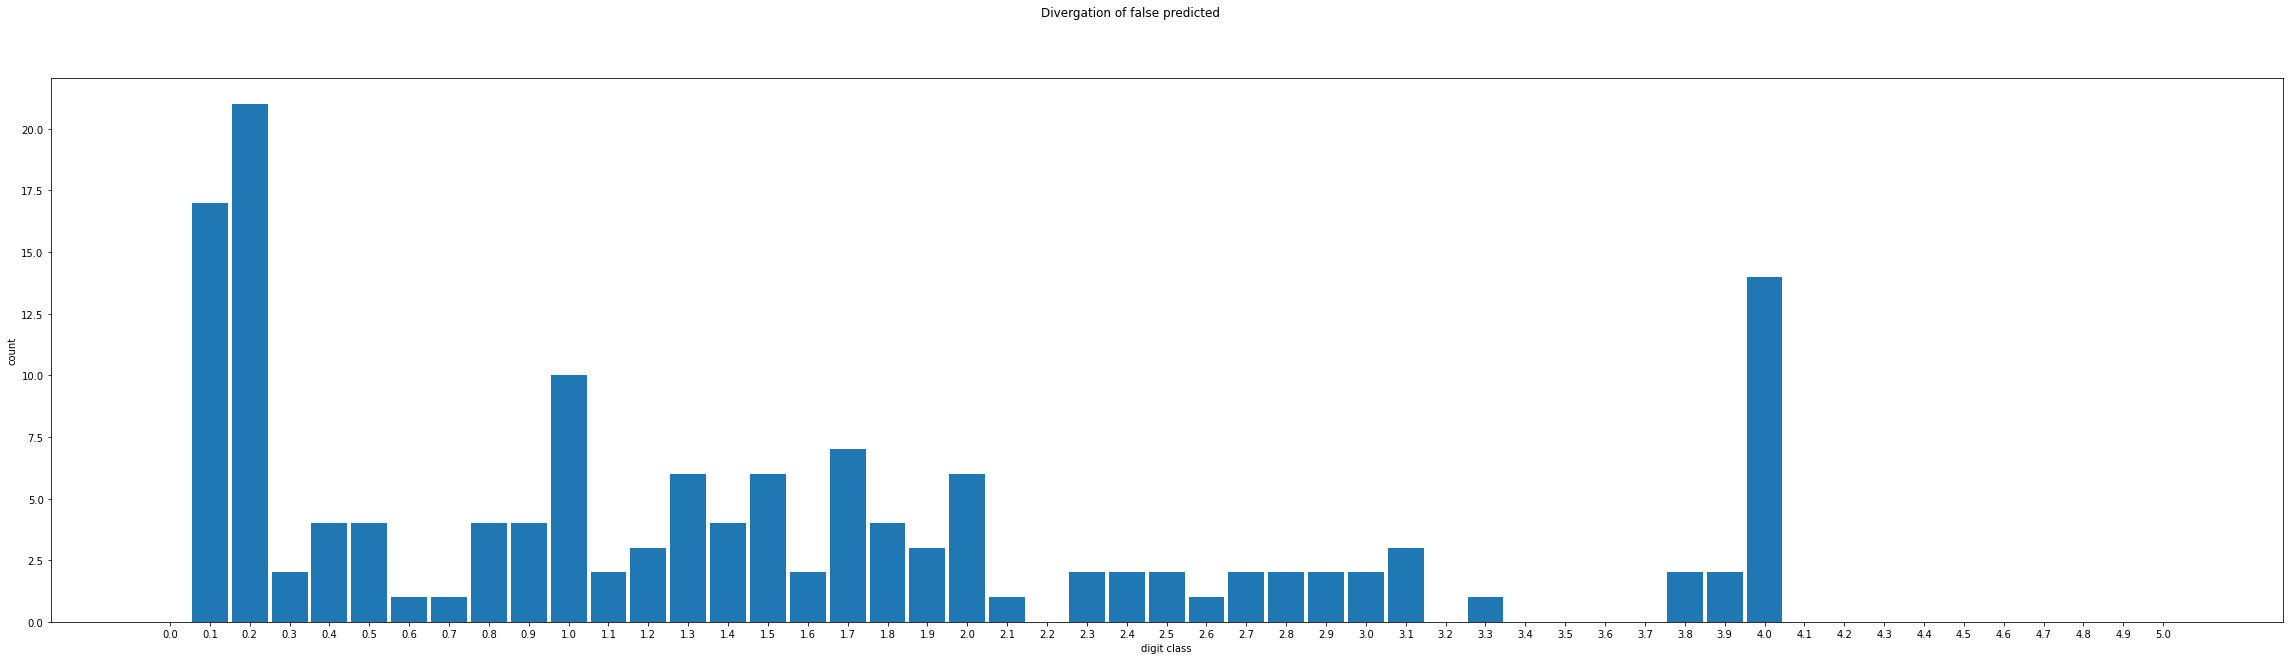

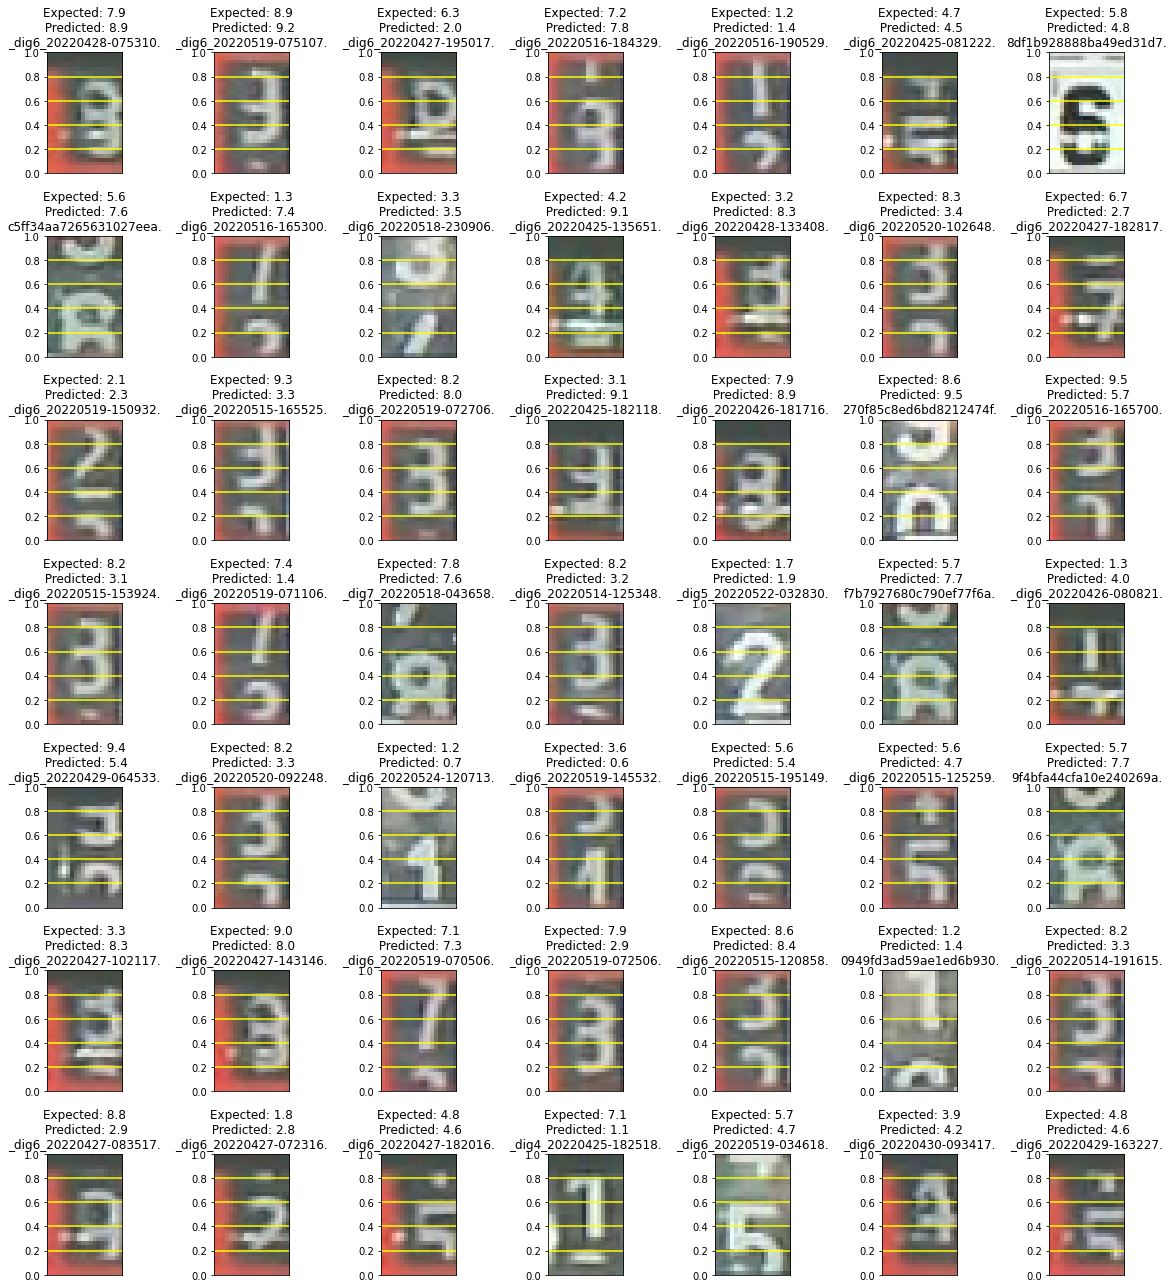

In [3]:
import numpy as np
import math
from operator import itemgetter
import shutil

img = []
pred_label = []

xz_data, yz_data, fz_data = ziffer_data('images/jomjol_update_20220608')
input_shape=xz_data[0].shape

model = keras.models.load_model("cnn32_best_transfer.h5")

predict_meter_digits()